# Construção do modelo para análise de sentimentos do Twitter

In [1]:
# importação de bibliotecas
import pandas as pd
import json

from nltk import word_tokenize
import nltk
import re #expreções regulares (regex)

In [2]:
# carregando o dataset
tweets_df = pd.read_csv("dataset/twitter_sentiments.csv")

# expandindo o espaço de exibição das celulas do pandas
pd.set_option('display.max_colwidth', None)

tweets_df.head()

,Unnamed: 0,id,tweet,label,tweet_clean
0,0,1512542155436441600,passar a madrugada vendo elite AMÉM,neutro,passar madrugada vendo elite amém
1,1,1512542146418683904,@joaoluizpedrosa Eu assisti algumas produções da @NetflixES e reparei que a maioria quase não tem negros no elenco… https://t.co/H8kBpauEz8,negativo,@joaoluizpedrosa assisti algumas produções @netflixes reparei maioria quase negros elenco…
2,2,1512542140013985796,Aff já terminei a 5° temperada de elite. Kkkk #Elite5,neutro,aff terminei 5° temperada elite kkkk #elite5
3,3,1512542138931855365,só tem elite na minha tl e eu nem assisto,neutro,elite tl assisto
4,4,1512542132510380034,chorei a ver elite?,neutro,chorei ver elite?


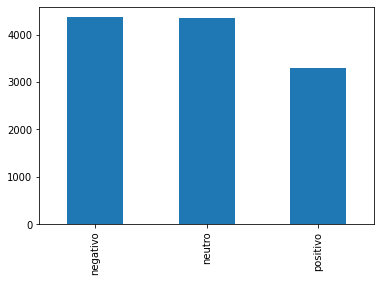

In [3]:
# Visualizando esses dados do label graficamente:
tweets_df.label.value_counts().plot(kind='bar');

In [4]:
# Tokenização especial para tweets
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

In [5]:
# Instanciando o objeto que faz a vetorização dos dados de texto:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

In [6]:
# Aplicando o vetorizador nos dados de texto e retorna uma matriz esparsa (contendo vários zeros):
freq_tweets = vectorizer.fit_transform(tweets_df['tweet_clean'])
type(freq_tweets)


scipy.sparse.csr.csr_matrix

In [7]:
# Visualizando a matris esparsa
print(freq_tweets.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
# Visualizando o número de linhas e colunas da matriz:
freq_tweets.shape

(12000, 14038)

## Vamos treinar o modelo

In [9]:
# Treinando o modelo de Machine Learning (Naive Bayes):
from sklearn.naive_bayes import MultinomialNB

modelo = MultinomialNB()
modelo.fit(freq_tweets, tweets_df.label)

MultinomialNB()

### Um pequeno teste para demonstrar o funcionamento do modelo

In [10]:
# Definindo instâncias de teste dentro de uma lista:
testes = [
    'Ai eu tava vendo uma foto tirada do céu de marte,  todo feliz, pensando: meu Deus, quanta vida tem nisso tudo!',
    'acabei de ter um mestrado e coincidentemente paulo guedes tirou 92% dos investimentos em ciência',
    'Prefeito visita stands no último dia da Semana Nacional de Ciência e Tecnologia',
    'Titan e jojo jogaram muito mal a lane phase',
    'deus abençoe a rockstar'
    ]

In [11]:
# Transformando os dados de teste em vetores de palavras:
freq_testes = vectorizer.transform(testes)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [12]:
# Fazendo a classificação com o modelo treinado:
for t, c in zip (testes,modelo.predict(freq_testes)):
    # 't' representa o tweet e 'c' a classificação de cada tweet.
    print("%s, %s" %(t, c))

Ai eu tava vendo uma foto tirada do céu de marte,  todo feliz, pensando: meu Deus, quanta vida tem nisso tudo!, positivo
acabei de ter um mestrado e coincidentemente paulo guedes tirou 92% dos investimentos em ciência, positivo
Prefeito visita stands no último dia da Semana Nacional de Ciência e Tecnologia, negativo
Titan e jojo jogaram muito mal a lane phase, negativo
deus abençoe a rockstar, positivo


In [13]:
# Probabilidades de cada classe:
print (modelo.classes_)
modelo.predict_proba(freq_testes).round(2)

['negativo' 'neutro' 'positivo']


array([[0.42, 0.  , 0.58],
       [0.03, 0.07, 0.9 ],
       [0.6 , 0.04, 0.35],
       [0.97, 0.  , 0.03],
       [0.1 , 0.05, 0.85]])

### Fim do pequeno teste

## Vamos preparar o modelo

In [14]:
# Função para aplicar as tags de negação:
def marque_negacao(texto):
    negacoes = ['não','not']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

## Criando modelos com Pipelines

### Modelos

In [15]:
# Vetorizando os dados e passando o classificador:
from sklearn.pipeline import Pipeline

pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])
pipeline_simples.fit(tweets_df.tweet_clean,tweets_df.label)

Pipeline(steps=[('counts', CountVectorizer()), ('classifier', MultinomialNB())])

In [16]:
# Pipeline que atribui tag de negações nas palavras(vetorizador com tag de negação):
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])
pipeline_negacoes.fit(tweets_df.tweet_clean,tweets_df.label)

Pipeline(steps=[('counts',
                 CountVectorizer(tokenizer=<function <lambda> at 0x00000238659809D0>)),
                ('classifier', MultinomialNB())])

In [17]:
#Criando um modelo com SVM (Support Vector Machine)
from sklearn import svm

# Pipeline simples (vetorizador com SVM):
pipeline_svm_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

In [18]:
# Pipeline com tag de negação (vetoriazador com tag de negação e SVM):
pipeline_svm_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

## Validando os Modelos com Validação Cruzada

In [19]:
# Fazendo o cross validation do modelo (pipeline_simples):
from sklearn.model_selection import cross_val_predict

resultados = cross_val_predict(pipeline_simples, tweets_df.tweet_clean,tweets_df.label, cv=10)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entr

In [20]:
# Medindo a acurácia média do modelo (pipeline_simples):
from sklearn import metrics

metrics.accuracy_score(tweets_df.label, resultados)

0.795

In [21]:
# Medidas de validação do modelo (pipeline_simples):
sentimento=['positivo', 'negativo', 'neutro']
print (metrics.classification_report(tweets_df.label, resultados, target_names=sentimento))

              precision    recall  f1-score   support

    positivo       0.72      0.85      0.78      4369
    negativo       0.83      0.78      0.81      4340
      neutro       0.87      0.74      0.80      3291

    accuracy                           0.80     12000
   macro avg       0.81      0.79      0.80     12000
weighted avg       0.80      0.80      0.80     12000



In [22]:
# Matriz de confusão (pipeline_simples):
print (pd.crosstab(tweets_df.label, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   negativo  neutro  positivo    All
Real                                       
negativo      3699     453       217   4369
neutro         795    3390       155   4340
positivo       613     227      2451   3291
All           5107    4070      2823  12000


### Automatizando a o processo de validação dos modelos

In [23]:
# Função para automatizar todo o processo para medir a acurácia:
def acuracia(modelo, tweets, classes):
  resultados = cross_val_predict(modelo, tweets, classes, cv=10)
  return 'Acurácia do modelo: {}'.format(metrics.accuracy_score(classes, resultados))

#### Vamos visualizar a acurácia para cada modelo criado

In [24]:
# Naive Bayes simples:
acuracia(pipeline_simples,tweets_df.tweet_clean,tweets_df.label)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entr

'Acurácia do modelo: 0.795'

In [25]:
# Naive Bayes com tag de negacoes:
acuracia(pipeline_negacoes,tweets_df.tweet_clean,tweets_df.label)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entr

'Acurácia do modelo: 0.5146666666666667'

In [26]:
# SVM linear simples:
acuracia(pipeline_svm_simples, tweets_df.tweet_clean, tweets_df.label)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entr

'Acurácia do modelo: 0.8774166666666666'

In [27]:
# SVM linear com tag de negacoes:
acuracia(pipeline_svm_negacoes, tweets_df.tweet_clean, tweets_df.label)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entr

'Acurácia do modelo: 0.5710833333333334'

### Modelo com a Tag de Negações

In [28]:
# Cross validation do modelo (pipeline_negacoes):
resultados = cross_val_predict(pipeline_negacoes, tweets_df.tweet_clean, tweets_df.label, cv=10)

C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
C:\Users\alsvi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:1208: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entr

In [29]:
# Medindo a acurácia do modelo (pipeline_negacoes):
metrics.accuracy_score(tweets_df.label, resultados)

0.5146666666666667

In [30]:
# Medidas de validação do modelo (pipeline_negacoes):
sentimento=['positivo','negativo','neutro']
print (metrics.classification_report(tweets_df.label, resultados, target_names=sentimento))

              precision    recall  f1-score   support

    positivo       0.48      0.62      0.54      4369
    negativo       0.57      0.49      0.52      4340
      neutro       0.51      0.41      0.45      3291

    accuracy                           0.51     12000
   macro avg       0.52      0.51      0.51     12000
weighted avg       0.52      0.51      0.51     12000



In [31]:
# Matriz de confusão do modelo (pipeline_negacoes):
print (pd.crosstab(tweets_df.label, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   negativo  neutro  positivo    All
Real                                       
negativo      2715     969       685   4369
neutro        1635    2119       586   4340
positivo      1287     662      1342   3291
All           5637    3750      2613  12000


### Avaliando modelo com Bigrams

In [32]:
# Bigrams (Naive Bayes multinominal):
vectorizer = CountVectorizer(ngram_range=(2,2))
freq_tweets = vectorizer.fit_transform(tweets_df.tweet_clean)
modelo = MultinomialNB()
modelo.fit(freq_tweets,tweets_df.label)

MultinomialNB()

In [33]:
# Cross validation (Naive Bayes multinominal):
resultados = cross_val_predict(modelo, freq_tweets, tweets_df.label, cv=10)

In [34]:
# Medindo a acurácia do modelo (Naive Bayes multinominal):
metrics.accuracy_score(tweets_df.label, resultados)

0.7529166666666667

In [35]:
# Medidas de validação do modelo (Naive Bayes multinominal):
sentimento=['positivo','negativo', 'neutro']
print (metrics.classification_report(tweets_df.label, resultados, target_names=sentimento))

              precision    recall  f1-score   support

    positivo       0.84      0.65      0.73      4369
    negativo       0.68      0.87      0.76      4340
      neutro       0.80      0.75      0.77      3291

    accuracy                           0.75     12000
   macro avg       0.77      0.75      0.75     12000
weighted avg       0.77      0.75      0.75     12000

